# PyTorch - Autograd (is what we need.)

Advanced Learning 2024





For SUBMISSION:  
  
Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 208066118
~~~

~~~
STUDENT GIT LINK: https://github.com/atarporat/Adv.-computational-learning-and-data-analysis---52025
~~~

In Addition, don't forget to add your ID to the files:  
`PS1_Part3_Autograd_2024_ID_[208066118].html`  



This part of the problem-set is divided into 2 sections: (a) a short introduction to PyTorch autograd, and (b) some practice questions.      
The practice questions cover calculating the gradients and updating the weights of a statistical model (linear regression), with and without PyTorch autograd.

##  A Short Intro to PyTorch Autograd

In PyTorch, autograd, short for automatic differentiation, is a core functionality that empowers you to efficiently calculate gradients during deep learning model training. It acts as a computational engine that automatically tracks the operations performed on your tensors and calculates the gradients of any loss function with respect to the model's learnable parameters.

**Why is Autograd Important?**

* Gradient Calculation: Deep learning relies heavily on gradient-based optimization algorithms like stochastic gradient descent (SGD). These algorithms adjust the weights and biases (learnable parameters) of your model based on the gradients of the loss function. Autograd automates this process, saving you from manually calculating complex derivatives.
* Efficient Backpropagation: Backpropagation is the algorithm at the heart of training deep neural networks. It propagates the error (loss) backward through the network, allowing the model to adjust its parameters in the direction that minimizes the loss. Autograd streamlines this process, making training more efficient.

**How Does Autograd Work?**

* Tracking Operations: When you enable autograd mode (with `torch.autograd.record_grad()`), PyTorch creates a computational graph in the background. This graph tracks all the operations performed on your tensors

* Backward Pass: Once you calculate a loss function (which typically depends on the output of your model), you can call the `backward()` method on the loss tensor. This triggers the backward pass through the computational graph.

* Gradient Calculation: As the backward pass traverses the graph, autograd computes the gradients of the loss function with respect to each learnable parameter in the network. These gradients indicate how much a specific parameter contributed to the overall loss.

* Parameter Update: By utilizing these gradients, optimization algorithms like SGD update the model's learnable parameters in a direction that minimizes the loss function. This iterative process continues until the model converges (achieves a desired level of performance).

**Key Points about Autograd:**

* Automatic
* Only for Learnable Parameters: Autograd tracks gradients only for tensors that have `requires_grad=True`.
* Dynamic vs. Static Graphs (Optional): PyTorch offers both dynamic computational graphs (eager execution) and static graphs (graph mode) for model development.



In [1]:
import time
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Using {device}!")


Using cpu!


##  0. Loading data and defining our model and loss

Load the California Housing Market dataset into a panda's DataFrame.  
In addition, scale the data (why?).

In [3]:
# Import the dataset.
cali_train_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
train_df = pd.read_csv(filepath_or_buffer=cali_train_path).drop(['longitude','latitude'],axis=1)
train_df_norm=(train_df-train_df.mean(axis=0))/train_df.std(axis=0) # column-wise operators
# Scale the labels:
print(f"Dataset dimension: {train_df_norm.shape}")
train_df_norm.head()

Dataset dimension: (17000, 7)


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.079639,1.361655,1.764152,-0.361173,-0.075996,-1.252506,-1.210522
1,-0.761850,2.296540,3.230346,-0.261858,-0.099401,-1.081451,-1.096713
2,-0.920744,-0.882436,-0.866931,-0.955326,-0.999223,-1.170071,-1.048430
3,-1.159087,-0.524171,-0.480216,-0.796769,-0.715753,-0.362590,-1.154480
4,-0.682402,-0.545731,-0.506313,-0.701809,-0.622130,-1.026424,-1.222593


We define a linear model to fit the scaled median house value to our data:  

**Our model :**.    

$$
\text{median\_house\_value}_i = y_i = \beta_0 + \beta_1 \text{housing\_median\_age}_i + \beta_2 \text{total\_rooms}_i + \beta_3 \text{total\_bedrooms}_i + \beta_4 \text{population}_i + \beta_5 \text{households}_i + \beta_6 \text{median\_income}_i
$$


**Our loss :**  
$$
\hat{L}_i(y_i,\hat{y}_i) = MSE(\text{y}_i,\hat{\text{y}}_i)
$$


## 1.  Manually Calculating the Gradients and Updating the Weights



Here we take a step back, and implement forward and backward propogation manually (so we can fully appreciate the autograd later...).

First, create numpy arrays for our data (X) and target (Y):

In [4]:
X = train_df_norm.drop(['median_house_value'],axis=1).to_numpy()
X =  np.c_[  np.ones(X.shape[0]), X ] # adding a column of "1"s for intercept
Y = train_df_norm['median_house_value']

print(f"X dimension: {X.shape}")
print(f"Y dimension: {Y.shape}")

X dimension: (17000, 7)
Y dimension: (17000,)


### 1.1 Calculating the weights analytically (15pts)
Apply linear algebra operations to `X` and `Y` to analytically solve the linear regression problem (solve for `W`).   
Please use only numpy. Round the weights to 3 decimal places.  

In [5]:
#### SOLUTION REQUIRED ####
t1 = time.time()

weights_rounded = np.round(np.linalg.inv(X.T @ X) @ X.T @ Y,3)
print(f"Total process time: {round(time.time() - t1,3)}")
print(f"The estimated weights using the analytic solution:\n {weights_rounded.round(3)}")

Total process time: 0.006
The estimated weights using the analytic solution:
 [ 0.     0.204 -0.375  0.362 -0.347  0.422  0.79 ]


Visualizing the errors:

/var/folders/h9/3fm04thx21d1wzwwx96lnrjh0000gn/T/ipykernel_33993/1668682842.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


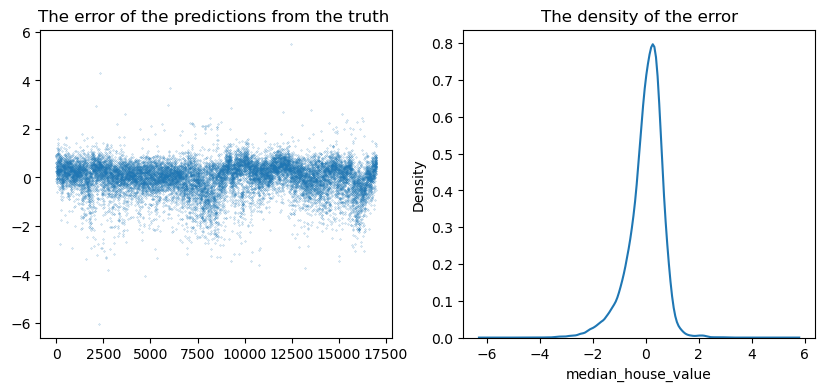

In [6]:
# Plot the errors and density (sanity check):
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
error = (np.matmul( X, weights_rounded)-Y)
ax1.scatter(range(Y.shape[0]), error ,s=0.05,alpha=0.7)
ax1.set_title("The error of the predictions from the truth ")
sns.kdeplot(error,ax=ax2)
ax2.set_title("The density of the error")
fig.show()


### 1.2 Calculating the weights using numpy and gradient descent (30pts)

Now you are ready to implement an algorithm that iteratively calculates the weights using numpy and gradient descent.

Please fill in your code in the `### YOUR CODE HERE` sections in the code block below.   
Please don't change the other parts of the code (unless specified).  

An epoch in machine learning means one complete pass of the training dataset through the algorithm.   

While developing your code, you may reduce the number of epochs.   
However, for final output please use the pre-defined epochs number.      





In [7]:
#### SOLUTION REQUIRED ####

t2 = time.time()

# Randomly initialize weights using numpy
b0 = np.random.rand() # FILL IN THE MISSING CODE
b1 = np.random.rand() # FILL IN THE MISSING CODE
b2 = np.random.rand() # FILL IN THE MISSING CODE
b3 = np.random.rand() # FILL IN THE MISSING CODE
b4 = np.random.rand() # FILL IN THE MISSING CODE
b5 = np.random.rand() # FILL IN THE MISSING CODE
b6 = np.random.rand() # FILL IN THE MISSING CODE

# Set learning rate (this can be a little fiddly, requires some tunning)
# Tip: start with a very small steps...

learning_rate = 0.01 # FILL IN THE MISSING CODE

# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):
    # Forward pass: compute predicted y
    # y_pred = b0x0 + b1x1 + b2x2 + b3x3 + b4x4 + b5x5 + b6x6
    Y_pred = b0*X[:,0] + b1*X[:,1] + b2*X[:,2] + b3*X[:,3] + b4*X[:,4] + b5*X[:,5] + b6*X[:,6] # FILL IN THE MISSING CODE

    # Compute and print loss
    loss = np.mean((Y_pred - Y) ** 2) #MSE loss# FILL IN THE MISSING CODE
    if t % 1000 == 0:
        print(f"Epoch:{t}, loss:{loss}")

    # Backprop to compute gradients of betas with respect to loss
    grad_y_pred = (2/len(Y))*(Y_pred - Y) # FILL IN THE MISSING CODE
    grad_b0 = (2/len(Y))*np.sum((Y_pred - Y)*X[:,0]) # FILL IN THE MISSING CODE
    grad_b1 = (2/len(Y))*np.sum((Y_pred - Y)*X[:,1]) # FILL IN THE MISSING CODE
    grad_b2 = (2/len(Y))*np.sum((Y_pred - Y)*X[:,2]) # FILL IN THE MISSING CODE
    grad_b3 = (2/len(Y))*np.sum((Y_pred - Y)*X[:,3]) # FILL IN THE MISSING CODE
    grad_b4 = (2/len(Y))*np.sum((Y_pred - Y)*X[:,4]) # FILL IN THE MISSING CODE
    grad_b5 = (2/len(Y))*np.sum((Y_pred - Y)*X[:,5]) # FILL IN THE MISSING CODE
    grad_b6 = (2/len(Y))*np.sum((Y_pred - Y)*X[:,6]) # FILL IN THE MISSING CODE

    # Update weights
    b0 -= learning_rate*grad_b0 # FILL IN THE MISSING CODE
    b1 -= learning_rate*grad_b1 # FILL IN THE MISSING CODE
    b2 -= learning_rate*grad_b2 # FILL IN THE MISSING CODE
    b3 -= learning_rate*grad_b3 # FILL IN THE MISSING CODE
    b4 -= learning_rate*grad_b4 # FILL IN THE MISSING CODE
    b5 -= learning_rate*grad_b5 # FILL IN THE MISSING CODE
    b6 -= learning_rate*grad_b6 # FILL IN THE MISSING CODE

print(f"Result: y_hat = {b0} x0 + {b1} x1 + {b2} x2 + {b3} x3\n + {b4} x4 + {b5} x5 + {b6} x6 \n")
print(f"Total process time: {round(time.time() - t2,3)}")

weights_gd_rounded = np.array([b0,b1,b2,b3,b4,b5,b6])
print(f"The estimated weights using the gradient descent solution:\n {weights_gd_rounded.round(3)}")

Epoch:0, loss:4.198148532146915
Epoch:1000, loss:0.4348345605714664
Epoch:2000, loss:0.42970677578154415
Epoch:3000, loss:0.4290643701790524
Epoch:4000, loss:0.42885903562198063
Result: y_hat = 3.469359132177406e-16 x0 + 0.203110946445542 x1 + -0.3602152322276155 x2 + 0.29521791193992275 x3
 + -0.35876665833119115 x4 + 0.4850739231022153 x5 + 0.7857683007687665 x6 

Total process time: 2.614
The estimated weights using the gradient descent solution:
 [ 0.     0.203 -0.36   0.295 -0.359  0.485  0.786]


### 1.3 Calculating the weights using PyTorch Tensors and gradient descent (25pts)

Here you are asked to implement the same manual gradient algorithm as above.  
However, this time please use PyTorch tensors and operators (instead of numpy).  

In [8]:
#### SOLUTION REQUIRED ####

# Creating data and target tensors:
tX = torch.tensor(X)
tY = torch.tensor(Y)

t3 = time.time()

# Randomly initialize weights using PyTorch
tb0 = torch.rand((), device =device)# FILL IN THE MISSING CODE
tb1 = torch.rand((), device =device) # FILL IN THE MISSING CODE
tb2 = torch.rand((),device =device) # FILL IN THE MISSING CODE
tb3 = torch.rand((), device =device) # FILL IN THE MISSING CODE
tb4 = torch.rand((), device =device) # FILL IN THE MISSING CODE
tb5 = torch.rand((), device =device) # FILL IN THE MISSING CODE
tb6 = torch.rand((), device =device) # FILL IN THE MISSING CODE

# Set learning rate
learning_rate = 0.01

# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):
    # Forward pass: compute predicted y
    # y_pred = b0x0 + b1x1 + b2x2 + b3x3 + b4x4 + b5x5 + b6x6
    tY_pred = (
    tb0 * tX[:, 0] +
    tb1 * tX[:, 1] +
    tb2 * tX[:, 2] +
    tb3 * tX[:, 3] +
    tb4 * tX[:, 4] +
    tb5 * tX[:, 5] +
    tb6 * tX[:, 6]
) # FILL IN THE MISSING CODE

    # Compute and print loss
    loss = ((tY - tY_pred)**2).mean()
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss}")

    # Backprop to compute gradients of betas with respect to loss
    grad_y_pred = ((2 / len(tY)) * (tY_pred - tY)).sum() # FILL IN THE MISSING CODE
    # print(grad_y_pred.sum())
    grad_b0 = (2 / len(tY)) * ((tY_pred - tY) * tX[:, 0]).sum()# FILL IN THE MISSING CODE
    grad_b1 = (2 / len(tY)) * ((tY_pred - tY) * tX[:, 1]).sum()# FILL IN THE MISSING CODE
    grad_b2 = (2 / len(tY)) * ((tY_pred - tY) * tX[:, 2]).sum()# FILL IN THE MISSING CODE
    grad_b3 = (2 / len(tY)) * ((tY_pred - tY) * tX[:, 3]).sum()# FILL IN THE MISSING CODE
    grad_b4 = (2 / len(tY)) * ((tY_pred - tY) * tX[:, 4]).sum()# FILL IN THE MISSING CODE
    grad_b5 = (2 / len(tY)) * ((tY_pred - tY) * tX[:, 5]).sum()# FILL IN THE MISSING CODE
    grad_b6 = (2 / len(tY)) * ((tY_pred - tY) * tX[:, 6]).sum()# FILL IN THE MISSING CODE

    # Update weights
    tb0 = tb0 - learning_rate * grad_b0 # FILL IN THE MISSING CODE
    tb1 = tb1 - learning_rate * grad_b1 # FILL IN THE MISSING CODE
    tb2 = tb2 - learning_rate * grad_b2 # FILL IN THE MISSING CODE
    tb3 = tb3 - learning_rate * grad_b3 # FILL IN THE MISSING CODE
    tb4 = tb4 - learning_rate * grad_b4 # FILL IN THE MISSING CODE
    tb5 = tb5 - learning_rate * grad_b5 # FILL IN THE MISSING CODE
    tb6 = tb6 - learning_rate * grad_b6 # FILL IN THE MISSING CODE

print(f"Result: y_hat = {tb0} x0 + {tb1} x1 + {tb2} x2 + {tb3} x3\n + {tb4} x4 + {tb5} x5 + {tb6} x6 \n")
print(f"Total process time: {round(time.time() - t3,3)}")

weights_gd_tensors_rounded = np.array([tb0.item(),tb1.item(),tb2.item(),tb3.item(),
                                       tb4.item(),tb5.item(),tb6.item()])
print(f"The estimated weights using the gradient descent on tensors:\n {weights_gd_tensors_rounded.round(3)}")

epoch:0, loss:8.45694840160019
epoch:1000, loss:0.431940948125938
epoch:2000, loss:0.42887495075361276
epoch:3000, loss:0.4286533720784616
epoch:4000, loss:0.42863361735988453
Result: y_hat = 3.5383465253753126e-16 x0 + 0.20422084616764258 x1 + -0.37642578573431773 x2 + 0.37195849183840046 x3
 + -0.3445217228260363 x4 + 0.4109646664557902 x5 + 0.7907501004756131 x6 

Total process time: 1.457
The estimated weights using the gradient descent on tensors:
 [ 0.     0.204 -0.376  0.372 -0.345  0.411  0.791]


### 1.4 Calculating the weights using PyTorch Autograd! (15pts)

Lastly, you can finally make a full transition to PyTorch autograd framework.   
Please replace your manual gradient calculations with PyTorch's automatic gradient tracking.   
In addition, instead of declaring the parameters separately, we will use one tensor to represent all of the model's parameters.  

In [9]:
# FILL IN THE MISSING CODE

t4 = time.time()
# Creating data and target tensors:
tX = torch.tensor(X, dtype=torch.float64)
tY = torch.tensor(Y, dtype=torch.float64)
# Randomly initialize weights using PyTorch
# we can use 1x7 tensor for all the weights. Make sure `requires_grad = True`.
tb = torch.rand(tX.shape[1], dtype=torch.float64, requires_grad=True) # FILL IN THE MISSING CODE

# Set learning rate
learning_rate = 0.01 # FILL IN THE MISSING CODE
# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):

    # Forward pass: compute predicted y
    tY_pred = torch.matmul(tX, tb) # FILL IN THE MISSING CODE #shape 17000, 7
    # Compute and print loss
    loss = torch.mean((tY_pred - tY)**2) # FILL IN THE MISSING CODE #MSE loss

    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss.item()}")

    # Backprop to compute gradients of betas with respect to loss
    loss.backward()

    with torch.no_grad():
        # Update weights
        tb -= learning_rate * tb.grad
        tb.grad = None # manually clear gradient after update


print(f"Result: betas = {tb} \n")
print(f"Total process time: {round(time.time() - t4,3)}")

weights_autograd_rounded = tb.cpu().detach().numpy()
print(f"The estimated weights using the pytorch autograd:\n {weights_autograd_rounded.round(3)}")

epoch:0, loss:2.693095983376626
epoch:1000, loss:0.4308104820139623
epoch:2000, loss:0.42884988908886457
epoch:3000, loss:0.4286958328228662
epoch:4000, loss:0.428661309445211
Result: betas = tensor([ 3.5173e-16,  2.0442e-01, -3.7979e-01,  3.8688e-01, -3.4179e-01,
         3.9678e-01,  7.9176e-01], dtype=torch.float64, requires_grad=True) 

Total process time: 0.466
The estimated weights using the pytorch autograd:
 [ 0.     0.204 -0.38   0.387 -0.342  0.397  0.792]


### 1.5 Conclusion (15pts)

1. Which method is the most accurate in finding the "true" weights? Why? Is it always applicabale? Hint - you should think about it from a statistical theory point of view.
2. Why did we scale the data ?  (answer with respect to the model/algorithm)
3. Do you think our model specification produced good results?  Why or why not? Justify your answer.
4. What can you say about the total process times between methods?
5. Can you suggest some improvements to the model definition?
6. Can you suggest some improvements to the solution algorithm?

YOUR ANSWERS HERE

1. Generally, it is the  **analytical method** that is closest to the true weight only when a closed-form solution exists. It comes from solving the optimization problem under certain conditions. This method is not always applicable, in which case there is no closed-form solution and numerical methods are needed to be used. This is the reason that we use **gradient descent** and **autograd**. They can be very senstive to intial conditions, learning rate and can find local minima which is not neccesarily a global minima. Specifiacally in the OLS case, the weights are  **BLUE** (Best Linear Unbiased Estimator), when the matrix \(X^TX\) is invertible, using the analytical solution.
   
2.  Ordinary Least Squares (OLS) regression minimizes the residual sum of squares: If features have vastly different scales, the optimization algorithm may disproportionately prioritize features with larger magnitudes, leading to poor performance and distortions. Moreover, scaling helps prevent issues with numerical instability during matrix operations (e.g., inversion of large or small matrices). Lastly, normalization ensures that all features contribute equally to the model during training.   
3.  To evaluate the model we can look at the behaviour of the loss (mean squared error, MSE), which measures how close the model's predictions are to the actual values. 
With **Numpy and Gradient Descent** The loss decreased steadily across epochs indicating that the model is leanring.
With **PyTorch Tensors and Gradient Descent**, the loss remained relatively low throughout the epochs and did not  decrease much later. This could indicate that it stopped learning as it progressed or it reached a local minima and and could not improve much more.
With **PyTorch Autograd**, the loss started relatively high and decreased over the epochs. The model learned and it makes sense since we started with randomly initialized weights.The, best-performing model would be determined by its performance on unseen data (test or validation set) rather than just the training loss. And this data might not include all other important features which could predict the price of a home.   
4.  AutoGrad is much faster (0.466 s) compared with numpy Gradient Decent (2.614 s). Calculating it anlytically is fastest (0.006 s) by an order of magnitude and is due to the fact that the is it takes less to compute (most difficult operation include inverting a matrix and multiplying matrices). Other Gradient Decent methods continually optimize based on contunually calculatign derivatives which is the reason for the longer time to run.

5. Feature Engineering: Add interaction terms (e.g., median_income * population) if you there might be a relationship between features. Alternatively one can try to change the exponent of each feature and see if there is a clearer relationship. This can be done by having polynomial (and other operation) features to model non-linear relationships.
We can use cross validation to make sure that the model generalizes well.


6.  Regularization: Add L2 Regularization (Ridge Regression) or L1 Regularization (Lasso Regression) to penalize large coefficients and prevent overfitting.
Change of the function: we can try different activation functions other than sigmoid, ReLU and see if there are imptovements.
Change of the leraning rate: we can play with the size of the learning rate and see if we could have larger steps (not too large) for fewer steps.
Change of the batch/epochs: we can take a smaller batch (mini batch) of samples to base the learning on and see if it improves the runnning time or take more batches and and see if there is a good imporvemnt in precision of the algorithm.
We can also introduce momntum to avoid falling into local minima, or use Learning Rate Scheduler to adjust step size dynamically.
Finally, we can run the model on the GPU for better performance.   

In [11]:
import os
print(os.getcwd())
!jupyter nbconvert --to html "/Users/atark/Documents/Asvanced Comutational Learning and Data Analysis/PS1_Part3_Autograd_2024_ID_208066118.ipynb"


/Users/atark/Documents/Asvanced Comutational Learning and Data Analysis
[NbConvertApp] Converting notebook /Users/atark/Documents/Asvanced Comutational Learning and Data Analysis/PS1_Part3_Autograd_2024_ID_208066118.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 465961 bytes to /Users/atark/Documents/Asvanced Comutational Learning and Data Analysis/PS1_Part3_Autograd_2024_ID_208066118.html


PART 2: Coming soon...